In [4]:
RATIO_DICT = {
    '2_2': (50, 400, 250, 200),
    '2_1': (0, 450, 200, 250),
    '1_1': (0, 450, 225, 225),
    '1_2': (0, 450, 225, 225)
}

# extract all frames from new video into np ndarray
from cv2 import VideoCapture
import cv2
import numpy as np
in_path = '/home/spencerloggia/Documents/full_length_videos/mitg05-533--07122020091530.avi'
FLIP = True
vidcap = VideoCapture(in_path)
n = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
w = 80
h = 80
X = np.zeros((n, h, w), dtype=np.uint8)
success, image = vidcap.read()
count = 0
while success and count < n:
    if FLIP:
        image = cv2.flip(image, 0)

    rat_tup = (0,0,0,0)
    if 'mitg05' in in_path and '533' in in_path:
        rat_tup = RATIO_DICT['2_2']
    else:
        raise KeyError
    image = image[rat_tup[0]:rat_tup[0] + 318, rat_tup[2]:rat_tup[2] + 318, 0]  # discard redundant channels and crop
    image = cv2.resize(image, (0, 0),
                       fx=.25,
                       fy=.25,
                       interpolation=cv2.INTER_NEAREST)  # downsample
    X[count, :, :] = image
    count+=1
    success, image = vidcap.read()
print(X.shape)

(98973, 80, 80)


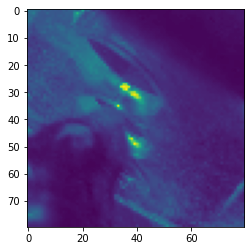

In [5]:
#NOT INCLUDE
# check some images
from matplotlib import pyplot as plt
plt.imshow(X[431])


In [3]:
#NOT INCLUDE
#apply any needed image transforms
#Preprocess
from skimage.filters import gabor
import math
X_filt = np.zeros(X.shape, dtype=np.int8)
for i in range(X.shape[0]):
    _, X_filt[i,:,:] = gabor(X[i,:,:], frequency=.8, theta=math.pi)

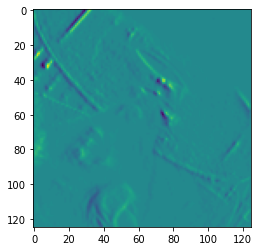

In [4]:
#NOT INCLUDE
# check some images
from matplotlib import pyplot as plt
plt.imshow(X_filt[431])


In [6]:
import pickle as pk
clf_file = open('./GBClassifier.pkl', 'rb')
clf = pk.load(clf_file)

In [7]:
X_filt = X.copy()
X_filt = X_filt.reshape(X_filt.shape[0], -1)
yhat = clf.predict(X_filt)

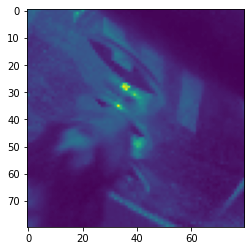

In [9]:
#NOT INCLUDE
positive = np.argwhere(yhat==1).reshape(-1)
plt.imshow(X_filt[positive[50]].reshape(80, 80))

In [17]:
#NOT INCLUDE
# max filter
from scipy.ndimage.filters import maximum_filter1d
y_filt = maximum_filter1d(yhat, size=15)
positive = np.argwhere(y_filt==1).reshape(-1)

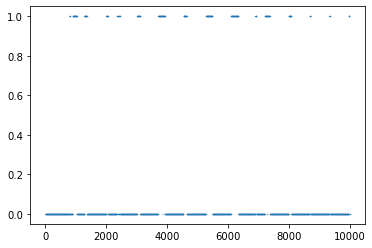

In [15]:
#NOT INCLUDE
plt.scatter(range(y_filt.shape[0])[:10000], y_filt[:10000], s=.01)

In [25]:
#NOT INCLUDE
#positive = np.argwhere(yhat==1).reshape(-1)
# extract trial start and end frames
trials = []
in_trial = False
prev = -1
for fnum in positive:
    if prev < fnum - 5:
        if prev > 0:
            trials[-1][1] = prev
        trials.append([fnum, -1])
    prev = fnum



In [10]:
#NOT INCLUDE
# load excel sheet data
klimbic = np.genfromtxt("/home/spencerloggia/Documents/Book1.csv", delimiter=',', dtype=int)
start_end = klimbic[1:, 6:8]


In [24]:
#NOT INCLUDE
# analysis
lengths = start_end[:,1] - start_end[:,0]
mean_len = np.mean(lengths)
min_length = np.min(lengths)
std_len = np.std(lengths)

In [12]:
#NOT INCLUDE
trials = np.array(trials)
pred_lengths = trials[:,1] - trials[:,0]
pred_lengths = pred_lengths.reshape(-1)

NameError: name 'trials' is not defined

In [26]:
#combine data
prev_five = [0]*20
trials = []
trial_counter = 0
i = 20
innum = False
while i < yhat.shape[0]:
    prev_five.pop(0)
    prev_five.append(yhat[i])
    if not innum and np.mean(prev_five) >=.85 and 0 not in yhat[i-20:i-17]:
        #trial found
        innum = True
        trials.append([i - 20, -1])
        trial_counter += 1
    if innum and np.mean(prev_five) < .15 and 1 not in yhat[i-20:i-17]:
        innum = False
        trials[-1][1] = i - 20
    i += 1


In [39]:
# make filtered y
trials = np.array(trials)
y_filt = np.zeros(yhat.shape[0])
for window in trials:
    y_filt[window[0]:window[1]+5] = 1

In [40]:
#load full res images and snip video
from cv2 import VideoCapture
from cv2 import VideoWriter
import cv2
import numpy as np
in_dir = '/home/spencerloggia/Documents/full_length_videos/'
fname = 'mitg05-533--07122020091530.avi'
FLIP = True
vidcap = VideoCapture(in_dir + fname)
n = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
success, image = vidcap.read()
if not success:
    raise IOError
count = 0
snip_count = 0
insnip = False
vid_write = None
while success and count < n:
    if y_filt[count] == 1:
        if not insnip:
            fourcc = cv2.VideoWriter_fourcc(*'MJPG')
            vid_write = VideoWriter('/home/spencerloggia/Projects/nbk_research/stimuli_recognition/snipping_test/snip_'
                                    + str(snip_count) + fname,fourcc,30,(768, 768))
            insnip = True
            snip_count += 1
        if FLIP:
            image = cv2.flip(image, 0)
        vid_write.write(image)
    elif insnip:
        insnip = False
        cv2.destroyAllWindows()
        vid_write.release()
    success, image = vidcap.read()
    count += 1

In [26]:
#NOT INCLUDE

#add train on any missed example, plus random sample of other, plus equal amount of negative data
# update serialized model
## Construct training set here (by default will use 100 random samples)
X_new = X_filt[423:440, :]
y_new = np.array([1]*7 + [0]*10)
clf.warm_start = True
clf.fit(X_new, y_new)


GradientBoostingClassifier(random_state=1018, warm_start=True)

In [27]:
#NOT INCLUDE

y_hat = clf.predict(X_filt)

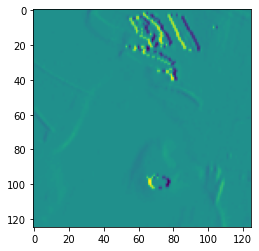

In [24]:
#NOT INCLUDE

plt.imshow(X_filt[424].reshape(125, 125))
